# HIML TakeHome2

In [ ]:
# first time only 
#pip install -r example-requirements.txt 


In [69]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split


Import

In [70]:
fname = join(getcwd(),'data','data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

Y = mat_contents['labels'].reshape(Nc)

# print sizes 
pd.DataFrame(np.array([N, Chno, Nc,len(Y)]))

,0
0,8192
1,5
2,850
3,850


Visualize data

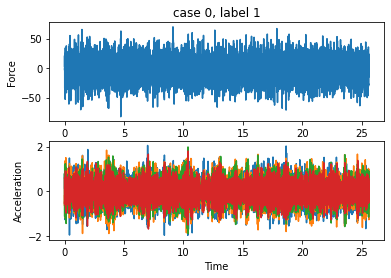

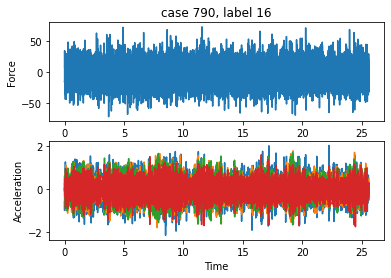

In [71]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [113]:
X_ = np.empty((0, 850), float)
chdata = dataset[:,1,:]
    # ch_corr = np.empty((30, 0), float)
ch_corr = []
for j in range(np.shape(chdata)[1]):
    res = AutoReg(chdata[:,j],lags=29,old_names=False).fit()
    ch_corr.append(res.params)
    # ch_corr = np.append(ch_corr,np.array(res).transpose(),axis=1)

Auto Regression 

In [115]:
# AutoRegression
X_ = np.empty((0, 850), float)
for i in range(4):
    chdata = dataset[:,i+1,:]
    ch_corr = []
    for j in range(np.shape(chdata)[1]):
        res = AutoReg(chdata[:,j],lags=29,old_names=False).fit()
        ch_corr.append(res.params)
    
    X_ = np.append(X_, np.array(ch_corr).transpose() , axis=0)
X = np.transpose(X_)

np.shape(X)


(850, 120)

PCA & Scale data

In [137]:
pca = PCA(random_state=0, whiten=True, n_components=.95)
X_pca = pca.fit_transform(X)
Xpca_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_pca)

nPC = np.shape(Xpca_scaled)[1]
nPC

6

Pelo PCA, vemos que 6 componentes principais representam 95% da variância.

 Visualização dos dados (sem PCA)

In [140]:
X_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X)
indDam = Y > 9
dfARred = pd.concat([pd.DataFrame(X_scaled),pd.DataFrame({'target':indDam})],axis=1)
dfARred.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,...,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,0.067002,-0.443458,-0.346024,-0.287717,-0.291574,-0.350982,-0.347265,-0.386836,-0.384332,-0.422236,-0.404556,-0.410750,-0.423837,-0.456713,-0.458497,-0.464975,-0.440029,-0.444498,-0.437695,-0.457526,-0.438045,-0.458762,-0.426900,-0.433488,-0.369185,-0.309316,-0.272308,-0.140084,-0.058739,-0.113909,0.014912,-0.565660,0.261986,-0.429657,-0.233103,-0.238689,-0.185212,-0.216181,-0.267858,-0.216773,...,0.190644,0.097308,0.302581,-0.068779,0.292720,-0.067819,0.188747,-0.176879,0.201344,-0.045437,0.082087,0.171235,-0.016490,0.016478,-0.057290,0.022218,0.048845,0.066295,-0.052003,0.049779,0.044818,0.148176,-0.218573,0.067721,-0.294806,0.064007,-0.276768,0.058937,-0.378349,0.034859,-0.364580,-0.083309,-0.407781,-0.024223,-0.355193,0.210504,-0.245325,0.026734,0.026257,0.090889
std,0.320791,0.318679,0.335566,0.329495,0.315096,0.302019,0.295994,0.276021,0.262825,0.246497,0.233964,0.225616,0.224525,0.226867,0.227954,0.224876,0.214682,0.212730,0.215517,0.229240,0.232704,0.243183,0.232357,0.241783,0.235452,0.255858,0.280661,0.342811,0.393685,0.457268,0.418223,0.399596,0.356668,0.399145,0.379069,0.408576,0.449201,0.403047,0.441847,0.417754,...,0.409036,0.439036,0.460942,0.411388,0.398110,0.402661,0.412338,0.350664,0.369573,0.288022,0.400137,0.521183,0.585212,0.567383,0.453167,0.555229,0.336043,0.556729,0.332355,0.486702,0.372382,0.479071,0.296442,0.493420,0.295980,0.450844,0.295276,0.417544,0.316288,0.446776,0.326460,0.364175,0.305091,0.374780,0.353185,0.316703,0.393812,0.356546,0.404983,0.311871
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.002673,-0.643232,-0.570684,-0.509880,-0.503685,-0.556724,-0.547381,-0.579162,-0.566350,-0.592161,-0.564134,-0.557315,-0.577755,-0.614091,-0.616423,-0.619177,-0.583214,-0.585715,-0.580836,-0.614397,-0.605417,-0.634225,-0.594490,-0.597583,-0.525592,-0.469852,-0.436120,-0.348955,-0.303897,-0.472167,-0.294278,-0.771625,0.145328,-0.698812,-0.529960,-0.549650,-0.505953,-0.532431,-0.590470,-0.531319,...,-0.087614,-0.114511,0.031563,-0.267477,0.160247,-0.234104,0.075126,-0.343156,0.051848,-0.217037,-0.180880,-0.293618,-0.441653,-0.6

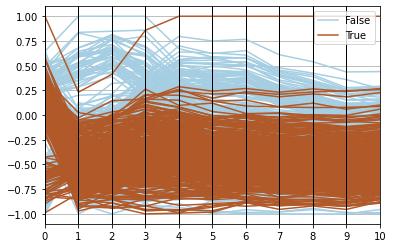

In [143]:
plt.figure()
pd.plotting.parallel_coordinates(dfARred,'target',colormap=plt.get_cmap('Paired'))
plt.xlim([0, 10])
plt.show()

Classificação dos dados sem PCA (escalados -1 a 1 acima)

In [122]:
#X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_scaled,Y,test_size=0.25,random_state=42)  
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",max_iter=200)
softmax_reg.fit(X_scaled,Y)
softmax_reg.score(X_scaled,Y)

0.9988235294117647

com os dados somente reduzidos pela AR, a acurácia do modelo em relaçáo a todo o database foi de 99.88%

Classificação dos dados com PCA 

In [130]:
softmax_reg.fit(Xpca_scaled,Y)
softmax_reg.score(Xpca_scaled,Y)



0.908235294117647

Para o caso dos dados reduzidos pelo AR+PCA, a acurácia do modelo cai para 90.8% 

A seguir, é testada a separaçao dos dados em grupos de treinamento e teste

In [131]:
#pequeno teste
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_scaled,Y,test_size=0.25,random_state=42)  
softmax_reg.fit(X1_train,Y1_train)
sc1 = softmax_reg.score(X1_test,Y1_test)
print(sc1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(Xpca_scaled,Y,test_size=0.25,random_state=42) 
softmax_reg.fit(X1_train,Y1_train) 
sc2 = softmax_reg.score(X1_test,Y1_test)
print(sc2)

1.0
0.9107981220657277


A acurácia do modelo com os pré-processamento AR e AR+PCA em relaçao ao test-set sao de 100% e 91%, respectivamente